In [ ]:
import os

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vidhikhubchandani","key":"9df015fadcc530a5e81a634a8a5848c6"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

100% 1.51G/1.52G [00:12<00:00, 189MB/s]
100% 1.52G/1.52G [00:12<00:00, 135MB/s]


In [ ]:
! unzip /content/ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Streaming output truncated to the last 5000 lines.
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-N

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import skimage
from skimage.restoration import denoise_nl_means, estimate_sigma, denoise_tv_chambolle, denoise_bilateral,denoise_wavelet, unsupervised_wiener
from scipy.signal import convolve2d as conv2
from skimage.filters import median
import copy
from tqdm import tqdm
from scipy import ndimage as nd
import multiprocessing
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from itertools import repeat
import zipfile
import os
from IPython.display import FileLink
from sklearn.svm import SVC
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from skimage.morphology import disk
from tensorflow.keras.optimizers import SGD
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install natsort
!pip install MedPy
import natsort
from medpy.filter.smoothing import anisotropic_diffusion
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 7.3 MB/s eta 0:00:00
  Created wheel for MedPy: filename=MedPy-0.4.0-py3-none-any.whl size=214949 sha256=d6c87106f6304c280fc202698e917575ddef38eea30fb973847b94a7659e012c
  Stored in directory: /root/.cache/pip/wheels/d4/32/c7/6380ab2edb8cca018d39a0f1d43250fd9791922c963117de46
Successfully built MedPy


In [ ]:
def Get_data(dir, catagories, data):
    for category in catagories:
        path = os.path.join(dir, category)
        class_number = catagories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path , img))
                new_image = cv2.resize(img_array,(128,128))
                data.append([new_image , class_number])
            except Exception as e:
                pass

data = []
Get_data("/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone", ["Cyst", "Normal","Stone","Tumor"], data)

In [ ]:
catagories = ["Cyst", "Normal","Stone","Tumor"]
print(catagories.index("Cyst"))
print(catagories.index("Normal"))
print(catagories.index("Stone"))
print(catagories.index("Tumor"))

0
1
2
3


In [ ]:
print('Number of Cyst images',len(os.listdir('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst')))
print('Number of Normal images',len(os.listdir('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal')))
print('Number of Stone images',len(os.listdir('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone')))
print('Number of Tumor images',len(os.listdir('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor')))

Number of Cyst images 3709
Number of Normal images 5077
Number of Stone images 1377
Number of Tumor images 2283


(128, 128, 3)


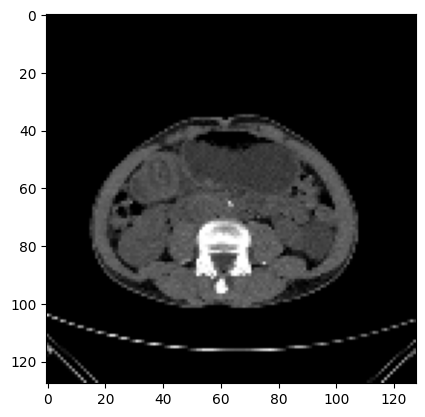

In [ ]:
print(data[143][0].shape)
plt.imshow(data[143][0])
plt.show()

In [ ]:
Features = []
Labels = []
for features , labels in data:
    Features.append(features)
    Labels.append(labels)
Features = np.array(Features)
Labels = np.array(Labels)

In [ ]:
Features

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [ ]:
Labels

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
def Processed(Processed_images):
    img_per_row = 4
    fig, ax = plt.subplots(nrows = 2, ncols = img_per_row, figsize=(10,10), subplot_kw = dict(xticks = [], yticks = []))
    for row in [0, 1]:
        for col in range(img_per_row):
            if(row * img_per_row + col == 7):
                break
            if(Processed_images[row * img_per_row + col][1] == "Bilateral_Denoised" or Processed_images[row * img_per_row + col][1] == "Wavelet_Denoised" or Processed_images[row * img_per_row + col][1] == "Non_Local_Means"):
                ax[row, col].imshow(Processed_images[row * img_per_row + col][0].astype('float64'), cmap = "gray")
            else:
                ax[row, col].imshow(Processed_images[row * img_per_row + col][0].astype('uint8'), cmap = "gray")
            ax[row, col].set_title(Processed_images[row * img_per_row + col][1])
            plt.axis('off')
    plt.show()

In [ ]:
def AnisotropicFilter_wholedataset(noised_dataset, niter, kappa, gamma, option, size):
    anisotropic_dataset = copy.deepcopy(noised_dataset)
    for i in tqdm(range(anisotropic_dataset.shape[0])):
        anisotropic_dataset[i] = anisotropic_diffusion(noised_dataset[i, :, :, :], niter=niter, kappa=kappa, gamma=gamma, option=option).reshape(size, size, 1)
    return anisotropic_dataset

def median_wholedataset(noised_dataset, filtersize, size):
    median_wholedata = copy.deepcopy(noised_dataset)
    for i in tqdm(range(noised_dataset.shape[0])):
        median_wholedata[i] = median(noised_dataset[i,:,:,:][:,:,0], np.ones((filtersize, filtersize))).reshape(size, size, 1)
    return median_wholedata

def wavelet_wholedataset(noised_dataset, sigma, wavelet_levels, size):
    wavelet_wholedata = copy.deepcopy(noised_dataset)
    for i in tqdm(range(noised_dataset.shape[0])):
        wavelet_wholedata[i] = denoise_wavelet(noised_dataset[i,:,:,:], sigma=sigma, channel_axis=-1, wavelet_levels=wavelet_levels, rescale_sigma=True).reshape(size, size, 1)
    return wavelet_wholedata

def BilateralFilter_wholedataset(noised_dataset, sigma_color, sigma_spatial, channel_axis, size):
    bilateral_dataset = copy.deepcopy(noised_dataset)
    for i in tqdm(range(bilateral_dataset.shape[0])):
        bilateral_dataset[i] = denoise_bilateral(noised_dataset[i, :, :, :], sigma_color = sigma_color, sigma_spatial=sigma_spatial, channel_axis=channel_axis).reshape(size, size, 1)
    return bilateral_dataset

def GaussianFilter_wholedataset(noised_dataset, sigma):
    gaussian_dataset = copy.deepcopy(noised_dataset)
    for i in tqdm(range(gaussian_dataset.shape[0])):
        gaussian_dataset[i] = nd.gaussian_filter(tuple(noised_dataset[i, :, :, :]), sigma=sigma)
    return gaussian_dataset

def non_local_mean(image):
    sigma_est = np.mean(estimate_sigma(image, channel_axis=-1))
    patch_kw = dict(patch_size = 5,      # 5x5 patches
                patch_distance = 6,  # 13x13 search area
                channel_axis = -1)
    denoise_fast = denoise_nl_means(image, h = 0.6 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw)
    return denoise_fast

def cv2bilateralFilter(image, d, sigmaColor, sigmaSpace):
    bilateral = cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
    bilateral = bilateral.astype('uint8')
    return bilateral


In [ ]:
true_min, true_max = np.min(Features[143]), np.max(Features[143])
dataRange = abs(true_min) + abs(true_max)
bilateral = cv2bilateralFilter(Features[143,:,:,:], 15, 75, 75)
print("PSNR: ", peak_signal_noise_ratio(Features[143,:,:,:], bilateral, data_range = dataRange))
print("MSE: ", mean_squared_error(Features[143,:,:,:], bilateral))
print("SSIM: ", ssim(Features[143,:,:,:], bilateral, multichannel = True, gaussian_weights = True, sigma=1.5, use_sample_covariance=False))

PSNR:  33.7666067946768
MSE:  27.316162109375
SSIM:  0.9398392577862035


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings

def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):
	if img.ndim == 3:
		warnings.warn("Only grayscale images allowed, converting to 2D matrix")
		img = img.mean(2)

	# initialize output array
	img = img.astype('float32')
	imgout = img.copy()

	# initialize some internal variables
	deltaS = np.zeros_like(imgout)
	deltaE = deltaS.copy()
	NS = deltaS.copy()
	EW = deltaS.copy()
	gS = np.ones_like(imgout)
	gE = gS.copy()

	# create the plot figure, if requested
	if ploton:
		import pylab as pl
		from time import sleep

		fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
		ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

		ax1.imshow(img,interpolation='nearest')
		ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
		ax1.set_title("Original image")
		ax2.set_title("Iteration 0")

		fig.canvas.draw()

	for ii in np.arange(1,niter):

		# calculate the diffs
		deltaS[:-1,: ] = np.diff(imgout,axis=0)
		deltaE[: ,:-1] = np.diff(imgout,axis=1)

		if 0<sigma:
			deltaSf=flt.gaussian_filter(deltaS,sigma);
			deltaEf=flt.gaussian_filter(deltaE,sigma);
		else:
			deltaSf=deltaS;
			deltaEf=deltaE;

		# conduction gradients (only need to compute one per dim!)
		if option == 1:
			gS = np.exp(-(deltaSf/kappa)**2.)/step[0]
			gE = np.exp(-(deltaEf/kappa)**2.)/step[1]
		elif option == 2:
			gS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
			gE = 1./(1.+(deltaEf/kappa)**2.)/step[1]

		E = gE*deltaE
		S = gS*deltaS
		NS[:] = S
		EW[:] = E
		NS[1:,:] -= S[:-1,:]
		EW[:,1:] -= E[:,:-1]

		# update the image
		imgout += gamma*(NS+EW)

		if ploton:
			iterstring = "Iteration %i" %(ii+1)
			ih.set_data(imgout)
			ax2.set_title(iterstring)
			fig.canvas.draw()
			# sleep(0.01)

	return imgout

def anisodiff3(stack,niter=1,kappa=50,gamma=0.1,step=(1.,1.,1.),option=1,ploton=False):
	# ...you could always diffuse each color channel independently if you
	# really want
	if stack.ndim == 4:
		warnings.warn("Only grayscale stacks allowed, converting to 3D matrix")
		stack = stack.mean(3)

	# initialize output array
	stack = stack.astype('float32')
	stackout = stack.copy()

	# initialize some internal variables
	deltaS = np.zeros_like(stackout)
	deltaE = deltaS.copy()
	deltaD = deltaS.copy()
	NS = deltaS.copy()
	EW = deltaS.copy()
	UD = deltaS.copy()
	gS = np.ones_like(stackout)
	gE = gS.copy()
	gD = gS.copy()

	# create the plot figure, if requested
	if ploton:
		import pylab as pl
		from time import sleep

		showplane = stack.shape[0]//2

		fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
		ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

		ax1.imshow(stack[showplane,...].squeeze(),interpolation='nearest')
		ih = ax2.imshow(stackout[showplane,...].squeeze(),interpolation='nearest',animated=True)
		ax1.set_title("Original stack (Z = %i)" %showplane)
		ax2.set_title("Iteration 0")

		fig.canvas.draw()

	for ii in np.arange(1,niter):

		# calculate the diffs
		deltaD[:-1,: ,:  ] = np.diff(stackout,axis=0)
		deltaS[:  ,:-1,: ] = np.diff(stackout,axis=1)
		deltaE[:  ,: ,:-1] = np.diff(stackout,axis=2)

		# conduction gradients (only need to compute one per dim!)
		if option == 1:
			gD = np.exp(-(deltaD/kappa)**2.)/step[0]
			gS = np.exp(-(deltaS/kappa)**2.)/step[1]
			gE = np.exp(-(deltaE/kappa)**2.)/step[2]
		elif option == 2:
			gD = 1./(1.+(deltaD/kappa)**2.)/step[0]
			gS = 1./(1.+(deltaS/kappa)**2.)/step[1]
			gE = 1./(1.+(deltaE/kappa)**2.)/step[2]

		# update matrices
		D = gD*deltaD
		E = gE*deltaE
		S = gS*deltaS

		# subtract a copy that has been shifted 'Up/North/West' by one
		# pixel. don't as questions. just do it. trust me.
		UD[:] = D
		NS[:] = S
		EW[:] = E
		UD[1:,: ,: ] -= D[:-1,:  ,:  ]
		NS[: ,1:,: ] -= S[:  ,:-1,:  ]
		EW[: ,: ,1:] -= E[:  ,:  ,:-1]

		# update the image
		stackout += gamma*(UD+NS+EW)

		if ploton:
			iterstring = "Iteration %i" %(ii+1)
			ih.set_data(stackout[showplane,...].squeeze())
			ax2.set_title(iterstring)
			fig.canvas.draw()
			# sleep(0.01)

	return stackout

<ipython-input-51-a3e0d74680f4>:14: UserWarning: Only grayscale images allowed, converting to 2D matrix
  warnings.warn("Only grayscale images allowed, converting to 2D matrix")


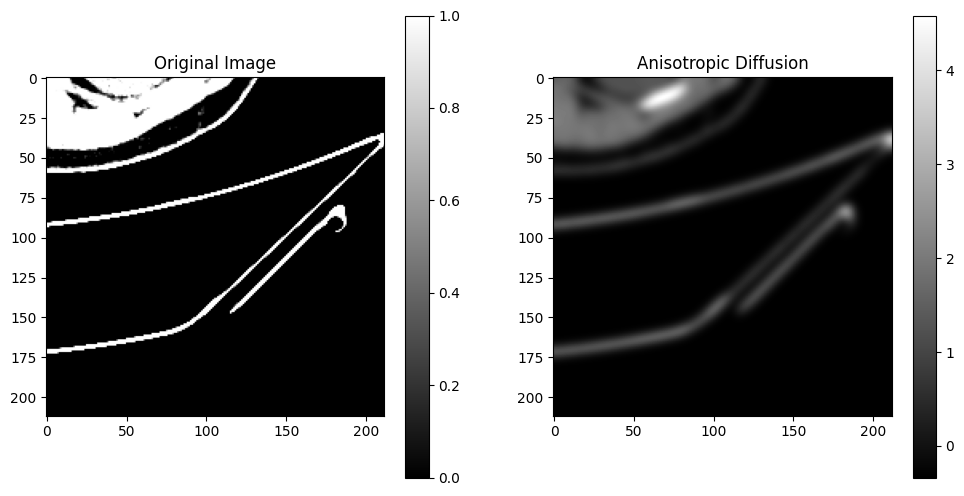

In [ ]:
img=io.imread('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (100).jpg')
img=img.astype(float)
img=img[300:600,300:600]
m=np.mean(img)
s=np.std(img)
nimg=(img-m)/s

# Apply anisotropic diffusion
niter = 50
kappa = 50
gamma = 0.1
step = (1., 1.)
sigma = 0
option = 1
aniso_diff_img = anisodiff(nimg, niter, kappa, gamma, step, sigma, option)

# Display original and filtered images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(nimg, cmap='gray')
plt.title('Original Image')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(aniso_diff_img, cmap='gray')
plt.title('Anisotropic Diffusion')
plt.colorbar()

<ipython-input-51-a3e0d74680f4>:14: UserWarning: Only grayscale images allowed, converting to 2D matrix
  warnings.warn("Only grayscale images allowed, converting to 2D matrix")


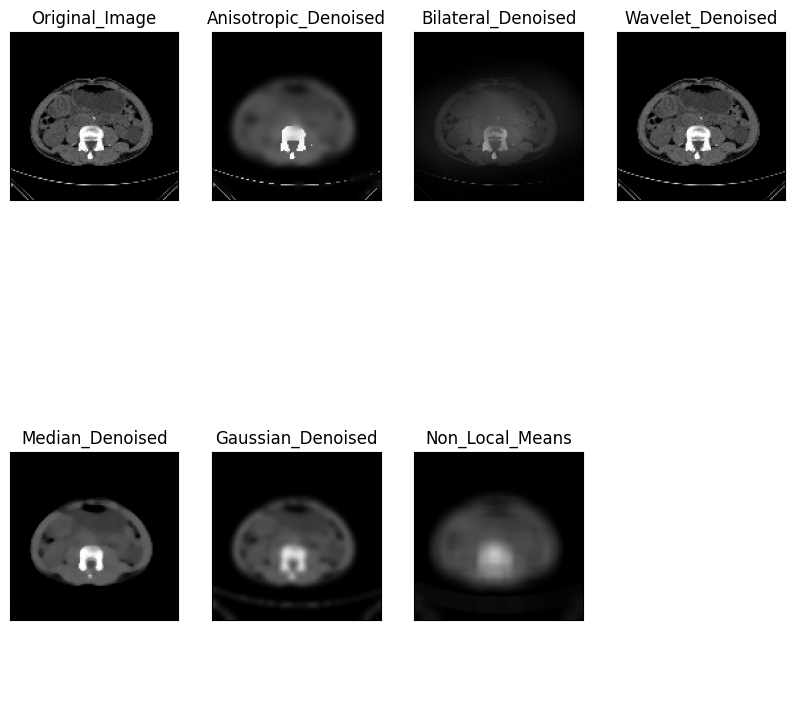

In [ ]:
aniso_diff_img = anisodiff(Features[143,:,:,:], niter, kappa, gamma, step, sigma, option)
# anisotropic_image = anisotropic_diffusion(Features[143,:,:,0], niter = 50, kappa = 5, gamma = 0.005, option=1)
bilateral_image = denoise_bilateral(Features[143], sigma_spatial = 10, channel_axis = -1)
wavelet_img = denoise_wavelet(Features[143, :, :, :], sigma = 0.12, channel_axis = -1,convert2ycbcr = True, method = 'BayesShrink', mode = 'soft', rescale_sigma = True).reshape(128, 128, 3)
median_img = median(Features[143, :, :, :][:,:,0], disk(3), mode = 'constant', cval = 0.0).reshape(128, 128, 1)
guassian_img = nd.gaussian_filter(tuple(Features[143, :, :, :]), sigma = 2)
non_local_mean_img = non_local_mean(Features[143])

Processed_images = [[Features[143, :, :, :], "Original_Image"], [aniso_diff_img, "Anisotropic_Denoised"], [bilateral_image, "Bilateral_Denoised"], [wavelet_img, "Wavelet_Denoised"], [median_img,"Median_Denoised"], [guassian_img, "Gaussian_Denoised"], [non_local_mean_img, "Non_Local_Means"]]

Processed(Processed_images)

In [ ]:
# Denoising the given data with anisotropic Filter
true_min, true_max = np.min(Features[0]), np.max(Features[0])
dataRange = abs(true_min) + abs(true_max)
anis_denoised = []
for i in range(len(Features)):
    aniso_diff_img = anisodiff(Features[i,:,:,:], niter, kappa, gamma, step, sigma, option)
    anis_denoised.append(aniso_diff_img)
anis_denoised = np.array(anis_denoised)

<ipython-input-51-a3e0d74680f4>:14: UserWarning: Only grayscale images allowed, converting to 2D matrix
  warnings.warn("Only grayscale images allowed, converting to 2D matrix")


In [ ]:
def crop(image_to_be_cropped):
    height, width = image_to_be_cropped.shape[:2]
    start_row, start_col = int(height * .24), int(width * .24)
    end_row, end_col = int(height * .78), int(width * .78)
#     start_row, start_col = int(height * .24), int(width * .24)
#     end_row, end_col = int(height * .42), int(width * .78)
    cropped_image = image_to_be_cropped[start_row:end_row, start_col:end_col]
    return cropped_image

def threshold(img, thresh1 = 254):
    return ((img > thresh1) * 255).astype('uint8')


# Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed.
def edge_detection(Image):
    img = cv2.Canny(Image, 100, 200)
    return img

# To see the pixel values division in the images
def hist_plot(Image):
    plt.hist(Image.flat, bins = 100, range = (0, 255))
    plt.show()

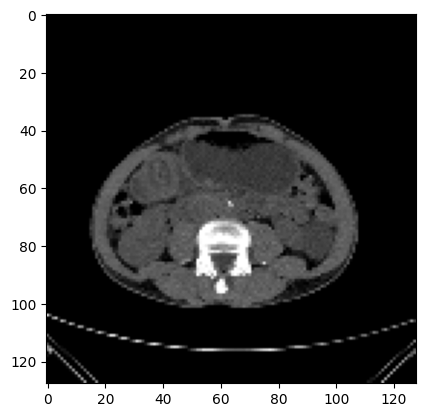

In [ ]:
# Convert BGR image to Gray Scale image
gray_image = cv2.cvtColor(data[143][0], cv2.COLOR_BGR2GRAY)

# expanding dimensions from 128,128 to 128,128,1
gray_image = np.expand_dims(gray_image, axis = -1)

plt.imshow(gray_image, cmap = "gray")
plt.show()

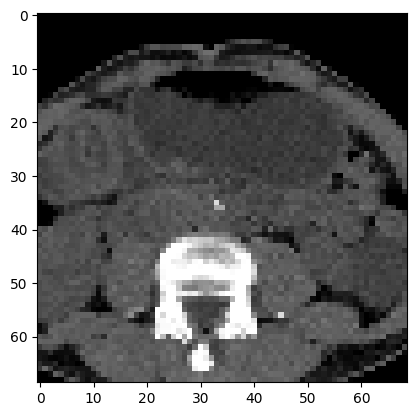

In [ ]:
# Crop a Image
cropped_image = crop(Features[143,:,:,:])
plt.imshow(cropped_image)
plt.show()

In [ ]:
cropped_image.shape

(69, 69, 3)

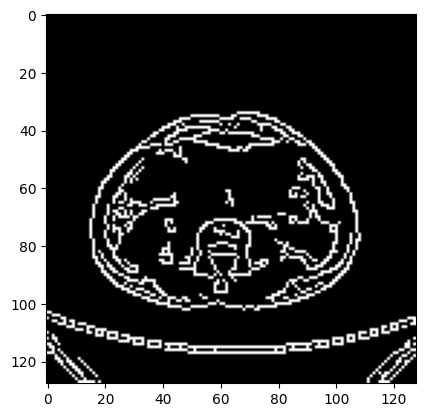

In [ ]:
# Edge Detection
img = edge_detection(gray_image)
plt.imshow(img, cmap = "gray")
plt.show()


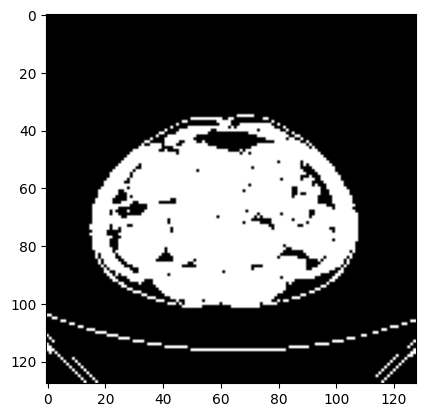

In [ ]:
re, th = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(th, cmap = "gray")
plt.show()


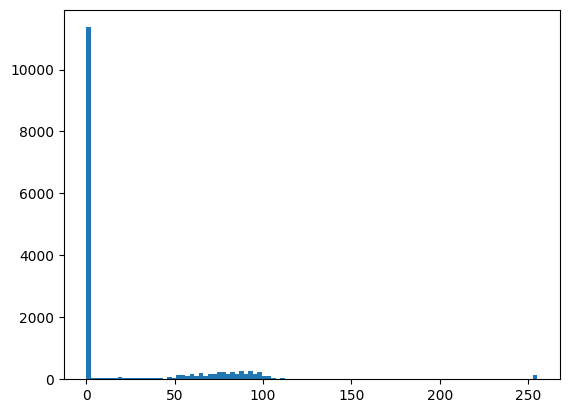

In [ ]:
hist_plot(gray_image)

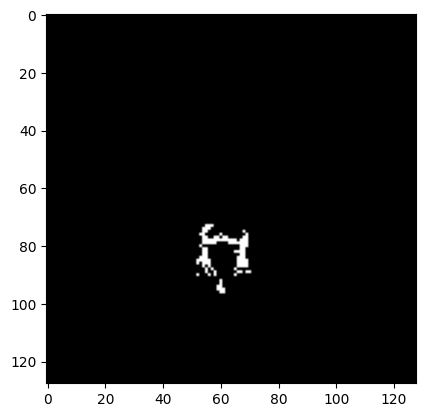

In [ ]:
img = threshold(gray_image)
plt.imshow(img, cmap = "gray")
plt.show()

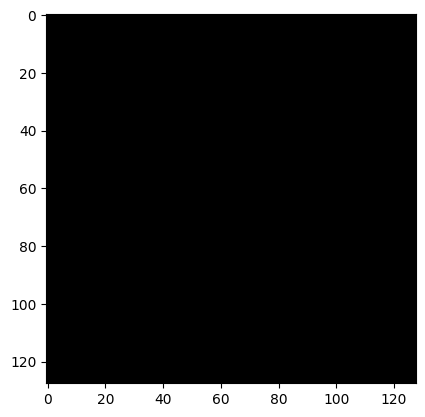

In [ ]:
lower_yellow = np.array([35, 255, 255])
upper_yellow = np.array([25, 50, 70])
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])
lower_white = np.array([180, 18, 255])
upper_white = np.array([0, 0, 231])
lower_black = np.array([180, 255, 30])
upper_black = np.array([0, 0, 0])

bgr_image = cv2.cvtColor(Features[143,:,:][:,:,0], cv2.COLOR_GRAY2BGR)

hsv = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lower_black, upper_black)

detected_output = cv2.bitwise_and(hsv, hsv, mask =  mask)
plt.imshow(detected_output, cmap = "gray")
plt.show()

In [ ]:
Cropped_Features = []
for i in range(len(Features)):
    cropped_image = crop(Features[i,:,:,:])
    Cropped_Features.append(cropped_image)
Cropped_Features = np.array(Cropped_Features)

In [ ]:
# On original images
bil_de = []
for i in range(len(Features)):
    bilateral_de = cv2.bilateralFilter(Features[i], 15, 75, 75)
    bil_de.append(bilateral_de)
bil_de = np.array(bil_de)


# On cropped images
bilateral_denoised = []
for i in range(len(Cropped_Features)):
    bilateral = cv2.bilateralFilter(Cropped_Features[i], 15, 75, 75)
    bilateral_denoised.append(bilateral)
bilateral_denoised = np.array(bilateral_denoised)

In [ ]:
thresholded = []
for i in range(len(bilateral_denoised)):
    temp = threshold(bilateral_denoised[i])
    thresholded.append(temp)
thresholded = np.array(thresholded)


# Cropped
thresholded = []
for i in range(len(Cropped_Features)):
    temp = threshold(Cropped_Features[i])
    thresholded.append(temp)
thresholded = np.array(thresholded)

In [ ]:
print(Features.shape)
print(Labels.shape)

(12446, 128, 128, 3)
(12446,)


In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Features, Labels, test_size = 0.30, random_state = 80, shuffle = True)

In [ ]:
print(len(Xtrain), len(Xtest), len(Ytrain), len(Ytest))

# Converting the list to a numpy array as a requirement for the input in fit function.
Xtrain=np.array(Xtrain)
Xtest=np.array(Xtest)
Ytrain=np.array(Ytrain)
Ytest=np.array(Ytest)


8712 3734 8712 3734


In [ ]:
# Model 1
model1 = Sequential([(Conv2D(128, 3, 3, input_shape=(128, 128, 3))),Activation('relu'),
                    MaxPool2D(pool_size=(2, 2)),Conv2D(128, 3, 3),
                    Activation('relu'), MaxPool2D(pool_size=(2, 2)),Flatten(),Dense(128),
                    Activation('relu'),Dropout(0.4),
                    Dense(1),Activation('sigmoid'),])

# Model 2
model2 = Sequential([Conv2D(filters = 32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(128,77,3)),
MaxPool2D(pool_size=(2,2),strides=2),
Conv2D(filters = 64,kernel_size=(3,3),activation='relu',padding='same'),
MaxPool2D(pool_size=(2,2),strides=2),
Flatten(),
Dense(units = 1,activation='softmax')
])


# Model 3
model3 = Sequential()

model3.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3), padding='same'))
model3.add(MaxPool2D(2))
model3.add(Dropout(0.2))


model3.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))
model3.add(Dropout(0.4))

model3.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))
model3.add(Dropout(0.5))


model3.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))

model3.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))

model3.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))
model3.add(Dropout(0.6))
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))

model3.add(Dense(1, activation='sigmoid'))

model1.summary()
model2.summary()
model3.summary()

import tensorflow as tf
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

sgd = SGD(learning_rate= 0.001, momentum = 0.9, nesterov = True)
model3.compile(loss = "binary_crossentropy", optimizer = sgd, metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 42, 42, 128)       3584      
                                                                 
 activation_16 (Activation)  (None, 42, 42, 128)       0         
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 21, 21, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 7, 7, 128)         147584    
                                                                 
 activation_17 (Activation)  (None, 7, 7, 128)         0         
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 3, 3, 128)         0         
 ng2D)                                               

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)

history = model3.fit(Xtrain, Ytrain, epochs = 15, batch_size = 20, callbacks = [early_stopping])

predictions = model3.predict(x = Xtest, batch_size = 20, verbose = 0)
Accuracy = model3.evaluate(Xtest, Ytest, verbose = 0)
print("Accuracy: ", Accuracy[1] * 100)

Epoch 1/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2983

436/436 [==============================] - 226s 513ms/step - loss: nan - accuracy: 0.2983
Epoch 2/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 213s 489ms/step - loss: nan - accuracy: 0.2976
Epoch 3/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 212s 485ms/step - loss: nan - accuracy: 0.2976
Epoch 4/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 203s 466ms/step - loss: nan - accuracy: 0.2976
Epoch 5/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 201s 462ms/step - loss: nan - accuracy: 0.2976
Epoch 6/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 202s 463ms/step - loss: nan - accuracy: 0.2976
Epoch 7/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 199s 455ms/step - loss: nan - accuracy: 0.2976
Epoch 8/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 201s 461ms/step - loss: nan - accuracy: 0.2976
Epoch 9/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 200s 459ms/step - loss: nan - accuracy: 0.2976
Epoch 10/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 202s 463ms/step - loss: nan - accuracy: 0.2976
Epoch 11/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 200s 459ms/step - loss: nan - accuracy: 0.2976
Epoch 12/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 198s 453ms/step - loss: nan - accuracy: 0.2976
Epoch 13/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 201s 461ms/step - loss: nan - accuracy: 0.2976
Epoch 14/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 199s 456ms/step - loss: nan - accuracy: 0.2976
Epoch 15/15
436/436 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2976

436/436 [==============================] - 200s 460ms/step - loss: nan - accuracy: 0.2976
Accuracy:  29.887521266937256


In [ ]:
Xtrain.shape

(8712, 128, 128, 3)

In [ ]:
Xtest.shape

(3734, 128, 128, 3)

In [ ]:
Xtrain_SVC = Xtrain.reshape(8712, 128 * 128 * 3)
Xtest_SVC = Xtest.reshape(3734, 128 * 128 * 3)

In [ ]:
model_SVC = SVC(C = 1,kernel='poly',gamma = 'auto')
model_SVC.fit(Xtrain_SVC, Ytrain)

SVC(C=1, gamma='auto', kernel='poly')

In [ ]:
train_accuracy = model_SVC.score(Xtrain_SVC, Ytrain)
print("Train_Accuracy", train_accuracy * 100)

Train_Accuracy 100.0


In [ ]:
prediction = model_SVC.predict(Xtest_SVC)
accuracy = model_SVC.score(Xtest_SVC , Ytest)

In [ ]:
print("Test_Accuracy ",accuracy * 100)

Test_Accuracy  100.0


In [ ]:
# cm = confusion_matrix(y_true = Ytest, y_pred = np.argmax(predictions,axis=-1))
cm = confusion_matrix(Ytest , (predictions > 0.75) * 1)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1116    0    0    0]
 [1545    0    0    0]
 [ 407    0    0    0]
 [ 666    0    0    0]]


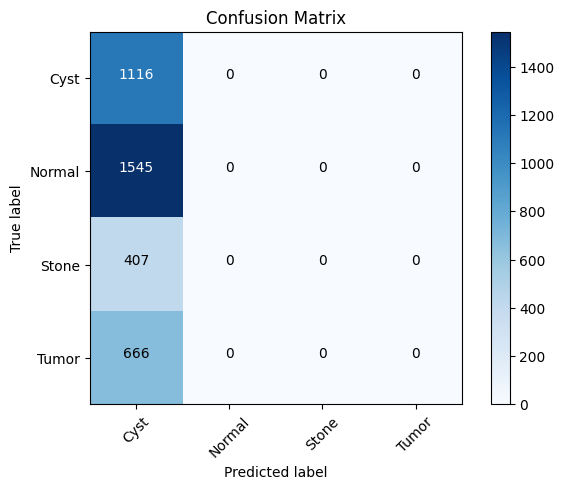

In [ ]:
cm_plot_labels = ['Cyst','Normal','Stone','Tumor']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [ ]:
def image_prediction(img):
    plt.imshow(img)
    img1=img.reshape(1,128,128,3)
    predict = model3.predict(img1)
    if ((predict > 0.75) * 1):
        print("The condition is normal and stable.")
    else:
        print("Person is having kidney stone(s)")

1/1 [==============================] - 0s 61ms/step
Person is having kidney stone(s)


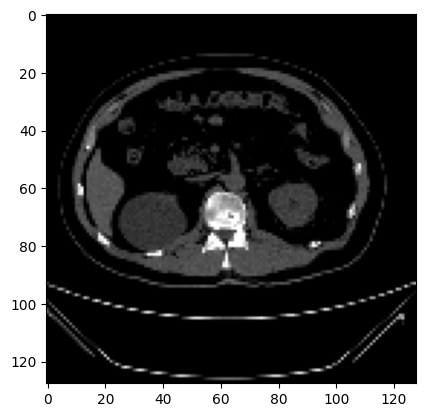

In [ ]:
image_prediction(Xtest[143])

1/1 [==============================] - 0s 28ms/step
Person is having kidney stone(s)


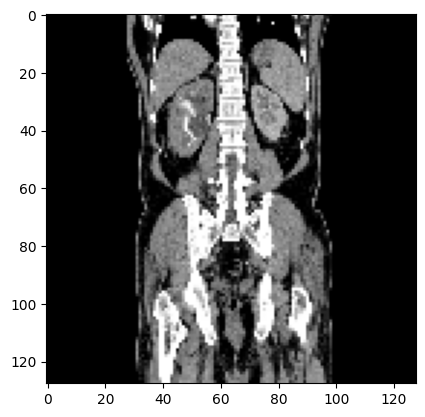

In [ ]:
image_prediction(Xtest[50])